# NER Prompt Engineering

## 1. Dependencies & Configuration

### 1.1 Import Dependencies

In [1]:
# Standard library
import json
import os
import sys
from pathlib import Path
import time
from datetime import datetime
from loguru import logger
import re

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('deep')
%matplotlib inline

# Add project root to path
try:
    project_root = Path.cwd().parent
except (FileNotFoundError, OSError):
    # If cwd is deleted, use the notebook's directory
    import inspect
    project_root = Path(inspect.getfile(inspect.currentframe())).resolve().parent.parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import custom modules
from src.data import (
    load_processed_data,
    create_validation_set,
    create_few_shot_examples,
    analyze_dataset_statistics,
    save_validation_and_examples
)

# Import prompt templates
from src.prompt import (
    build_zero_shot_prompt,
    build_few_shot_prompt,
    build_chain_of_thought_prompt,
)

# Import evaluation utilities
from src.utils.evaluation import (
    parse_ner_response,
    calculate_accuracy,
    print_evaluation_results,
    print_comparison_table,
    save_json_with_numpy_conversion,
)


### 1.2 Configuration

In [2]:
# Configuration
CONFIG = {
    # Model
    'model_name': 'mistral:7b',
    'ollama_host': os.getenv('OLLAMA_HOST', 'http://127.0.0.1:11434'),
    'temperature': 0.1,
    'max_tokens': 512,
    
    # Data
    'validation_size': 241,
    'validation_strategy': 'balanced',  # 'random', 'diverse', 'balanced'
    'num_few_shot_examples': 3,
    
    # Experiment
    'test_size': 50,
    'random_seed': 42,
    'verbose': False,
}

os.environ['OLLAMA_HOST'] = CONFIG['ollama_host']

logger.info("  Configuration:")
print(json.dumps(CONFIG, indent=2))

2025-12-14 09:47:59.480 | INFO     | __main__:<module>:22 -   Configuration:


{
  "model_name": "mistral:7b",
  "ollama_host": "http://127.0.0.1:11434",
  "temperature": 0.1,
  "max_tokens": 512,
  "validation_size": 241,
  "validation_strategy": "balanced",
  "num_few_shot_examples": 3,
  "test_size": 50,
  "random_seed": 42,
  "verbose": false
}


## 2. Data Preparation

### 2.1 Load Dataset

In [3]:
# Load dataset
logger.info("Loading VLSP 2018 NER dataset...")
data_splits = load_processed_data()

logger.info(f"\n Dataset loaded:")
for split_name, split_data in data_splits.items():
    logger.info(f"  {split_name:>5}: {len(split_data):>4} examples")

# Show sample
sample = data_splits['dev'][0]
logger.info(f"\n Sample:")
logger.info(f"  ID: {sample['id']}")
logger.info(f"  Topic: {sample['topic']}")
logger.info(f"  Title: {sample['title'][:60]}...")
logger.info(f"  Text: {sample['text'][:100]}...")
logger.info(f"  Entities:")
for entity_type, entities in sample['ground_truth'].items():
    logger.info(f"    {entity_type}: {len(entities)}")

2025-12-14 09:47:59.503 | INFO     | __main__:<module>:2 - Loading VLSP 2018 NER dataset...
2025-12-14 09:47:59.537 | INFO     | __main__:<module>:5 - 
 Dataset loaded:
2025-12-14 09:47:59.537 | INFO     | __main__:<module>:7 -   train:  781 examples
2025-12-14 09:47:59.537 | INFO     | __main__:<module>:7 -     dev:  260 examples
2025-12-14 09:47:59.538 | INFO     | __main__:<module>:7 -    test:  241 examples
2025-12-14 09:47:59.538 | INFO     | __main__:<module>:11 - 
 Sample:
2025-12-14 09:47:59.538 | INFO     | __main__:<module>:12 -   ID: 23352806
2025-12-14 09:47:59.538 | INFO     | __main__:<module>:13 -   Topic: Doi Song
2025-12-14 09:47:59.539 | INFO     | __main__:<module>:14 -   Title: Dân văn phòng coi chừng 'chết sớm' vì thứ ai cũng đang mắc n...
2025-12-14 09:47:59.539 | INFO     | __main__:<module>:15 -   Text: Các nhà khoa học cho rằng, nếu dân văn phòng cứ ngồi lì làm việc suốt 8 tiếng sẽ có nguy cơ chết sớm...
2025-12-14 09:47:59.539 | INFO     | __main__:<module>:16

### 2.2 Create Validation Set

In [4]:
# Create validation set
validation_set = create_validation_set(
    dev_data=data_splits['dev'],
    size=CONFIG['validation_size'],
    strategy=CONFIG['validation_strategy'],
    seed=CONFIG['random_seed']
)

# Analyze statistics
val_stats = analyze_dataset_statistics(validation_set)

logger.info(f"\n Validation set: {len(validation_set)} examples")
logger.info(f"\n Statistics:")
logger.info(f"  Total entities: {sum(val_stats['entity_counts'].values())}")
logger.info(f"  Entity breakdown:")
for entity_type, count in val_stats['entity_counts'].items():
    logger.info(f"    {entity_type:>15}: {count:>4}")
logger.info(f"  Avg entities/example: {val_stats['avg_entities_per_example']:.1f}")
logger.info(f"  Avg text length: {val_stats['avg_text_length']:.0f} chars")
logger.info(f"  Examples with all types: {val_stats['examples_with_all_types']}")

2025-12-14 09:47:59.569 | INFO     | __main__:<module>:12 - 
 Validation set: 240 examples
2025-12-14 09:47:59.570 | INFO     | __main__:<module>:13 - 
 Statistics:
2025-12-14 09:47:59.570 | INFO     | __main__:<module>:14 -   Total entities: 2759
2025-12-14 09:47:59.571 | INFO     | __main__:<module>:15 -   Entity breakdown:
2025-12-14 09:47:59.571 | INFO     | __main__:<module>:17 -              person:  986
2025-12-14 09:47:59.571 | INFO     | __main__:<module>:17 -       organizations:  545
2025-12-14 09:47:59.572 | INFO     | __main__:<module>:17 -             address: 1228
2025-12-14 09:47:59.572 | INFO     | __main__:<module>:18 -   Avg entities/example: 11.5
2025-12-14 09:47:59.572 | INFO     | __main__:<module>:19 -   Avg text length: 2455 chars
2025-12-14 09:47:59.573 | INFO     | __main__:<module>:20 -   Examples with all types: 119


### 2.3 Create Few-Shot Examples

In [5]:
# Create few-shot examples
few_shot_examples = create_few_shot_examples(
    train_data=data_splits['train'],
    num_examples=CONFIG['num_few_shot_examples'],
    quality_filter=True,
    max_text_length=800,
    seed=CONFIG['random_seed']
)

logger.info(f"\n Created {len(few_shot_examples)} few-shot examples")
logger.info(f"\n Preview:")
for i, example in enumerate(few_shot_examples, 1):
    output = example['output']
    total = sum(len(output[k]) for k in ['person', 'organizations', 'address'])
    logger.info(f"  Example {i}:")
    logger.info(f"    Length: {len(example['input'])} chars")
    logger.info(f"    Entities: {total} (P:{len(output['person'])}, "
          f"O:{len(output['organizations'])}, A:{len(output['address'])})")

# Save for reproducibility
val_path, examples_path = save_validation_and_examples(
    validation_set, few_shot_examples, output_dir="outputs"
)
logger.info(f"\n Saved to outputs/")

2025-12-14 09:47:59.599 | INFO     | __main__:<module>:10 - 
 Created 3 few-shot examples
2025-12-14 09:47:59.600 | INFO     | __main__:<module>:11 - 
 Preview:
2025-12-14 09:47:59.600 | INFO     | __main__:<module>:15 -   Example 1:
2025-12-14 09:47:59.600 | INFO     | __main__:<module>:16 -     Length: 642 chars
2025-12-14 09:47:59.600 | INFO     | __main__:<module>:17 -     Entities: 7 (P:2, O:3, A:2)
2025-12-14 09:47:59.601 | INFO     | __main__:<module>:15 -   Example 2:
2025-12-14 09:47:59.601 | INFO     | __main__:<module>:16 -     Length: 457 chars
2025-12-14 09:47:59.601 | INFO     | __main__:<module>:17 -     Entities: 6 (P:2, O:1, A:3)
2025-12-14 09:47:59.601 | INFO     | __main__:<module>:15 -   Example 3:
2025-12-14 09:47:59.601 | INFO     | __main__:<module>:16 -     Length: 695 chars
2025-12-14 09:47:59.601 | INFO     | __main__:<module>:17 -     Entities: 6 (P:1, O:1, A:4)
2025-12-14 09:47:59.610 | INFO     | __main__:<module>:24 - 
 Saved to outputs/


In [6]:
# Define NER Extractor Class
import ollama

class PromptBasedNERExtractor:
    """
    NER Extractor using prompt engineering with Ollama.
    
    Supports multiple prompting strategies: zero-shot, few-shot, and chain-of-thought.
    Uses prompt templates from src.prompt and evaluation utilities from src.utils.
    """
    
    def __init__(
        self,
        model_name: str = "mistral-3:14b",
        ollama_host: str = "http://127.0.0.1:11434",
        temperature: float = 0.1,
        max_tokens: int = 512,
        examples: list = None,
        verbose: bool = False
    ):
        """
        Initialize the NER extractor.
        
        Args:
            model_name: Name of the Ollama model to use
            ollama_host: Ollama server host URL
            temperature: Sampling temperature (0-1)
            max_tokens: Maximum tokens to generate
            examples: Few-shot examples for prompting
            verbose: Whether to print debug information
        """
        self.model_name = model_name
        self.ollama_host = ollama_host
        self.temperature = temperature
        self.max_tokens = max_tokens
        self.examples = examples or []
        self.verbose = verbose
        
        # Configure ollama client
        self.client = ollama.Client(host=ollama_host)
        
    def extract(self, text: str, strategy: str = "zero-shot") -> dict:
        """
        Extract named entities from text using specified strategy.
        
        Args:
            text: Input Vietnamese text
            strategy: One of "zero-shot", "few-shot", or "cot" (chain-of-thought)
            
        Returns:
            Dictionary with keys: person, organizations, address
        """
        # Build prompt using templates from src.prompt
        if strategy == "zero-shot":
            prompt = build_zero_shot_prompt(text)
        elif strategy == "few-shot":
            prompt = build_few_shot_prompt(text, self.examples)
        elif strategy == "cot":
            prompt = build_chain_of_thought_prompt(text)
        else:
            raise ValueError(f"Unknown strategy: {strategy}")
        
        if self.verbose:
            logger.info(f"\n=== Prompt (first 500 chars) ===\n{prompt[:500]}...\n")
        
        try:
            # Call Ollama
            response = self.client.generate(
                model=self.model_name,
                prompt=prompt,
                options={
                    "temperature": self.temperature,
                    "num_predict": self.max_tokens,
                }
            )
            
            response_text = response['response']
            
            if self.verbose:
                logger.info(f"\n=== Response ===\n{response_text}\n")
            
            # Parse response using utility from src.utils
            entities = parse_ner_response(response_text)
            return entities
            
        except Exception as e:
            if self.verbose:
                logger.info(f"Error during extraction: {e}")
            return {"person": [], "organizations": [], "address": []}
    
    def batch_extract(
        self,
        texts: list,
        strategy: str = "zero-shot",
        show_progress: bool = True
    ) -> list:
        """
        Extract entities from multiple texts.
        
        Args:
            texts: List of input texts
            strategy: Prompting strategy to use
            show_progress: Whether to show progress bar
            
        Returns:
            List of entity dictionaries
        """
        results = []
        iterator = tqdm(texts, desc=f"Extracting ({strategy})") if show_progress else texts
        
        for text in iterator:
            result = self.extract(text, strategy=strategy)
            results.append(result)
        
        return results

logger.info("PromptBasedNERExtractor class defined")
logger.info("Evaluation utilities imported from src.utils")

2025-12-14 09:47:59.878 | INFO     | __main__:<module>:117 - PromptBasedNERExtractor class defined
2025-12-14 09:47:59.879 | INFO     | __main__:<module>:118 - Evaluation utilities imported from src.utils


## 3. Prompting Strategies

### 3.1 Initialize Extractor

In [7]:
# Initialize extractor
extractor = PromptBasedNERExtractor(
    model_name=CONFIG['model_name'],
    ollama_host=CONFIG['ollama_host'],
    temperature=CONFIG['temperature'],
    max_tokens=CONFIG['max_tokens'],
    examples=few_shot_examples,
    verbose=CONFIG['verbose']
)

logger.info(f" Extractor initialized")
logger.info(f"   Model: {CONFIG['model_name']}")
logger.info(f"   Temperature: {CONFIG['temperature']}")
logger.info(f"   Few-shot examples: {len(extractor.examples)}")

2025-12-14 09:47:59.931 | INFO     | __main__:<module>:11 -  Extractor initialized
2025-12-14 09:47:59.932 | INFO     | __main__:<module>:12 -    Model: mistral:7b
2025-12-14 09:47:59.932 | INFO     | __main__:<module>:13 -    Temperature: 0.1
2025-12-14 09:47:59.933 | INFO     | __main__:<module>:14 -    Few-shot examples: 3


### 3.2 Test on Single Example

In [8]:
# Test on single example
test_idx = 6
test_example = validation_set[test_idx]

logger.info(f"Testing example {test_idx + 1}:")
logger.info(f"\nText: {test_example['text'][:200]}...")
logger.info(f"\nGround Truth: {json.dumps(test_example['ground_truth'], ensure_ascii=False, indent=2)}")

logger.info("\n" + "="*80)
logger.info("Testing prompting strategies...")

# Zero-shot
logger.info("\n1.  Zero-shot:")
zero_result = extractor.extract(test_example['text'], strategy='zero-shot')
print(json.dumps(zero_result, ensure_ascii=False, indent=2))

# Few-shot
logger.info("\n2.  Few-shot:")
few_result = extractor.extract(test_example['text'], strategy='few-shot')
print(json.dumps(few_result, ensure_ascii=False, indent=2))

# Chain-of-Thought
logger.info("\n3.  Chain-of-Thought:")
cot_result = extractor.extract(test_example['text'], strategy='cot')
print(json.dumps(cot_result, ensure_ascii=False, indent=2))

logger.info("\n Test complete!")

2025-12-14 09:47:59.963 | INFO     | __main__:<module>:5 - Testing example 7:
2025-12-14 09:47:59.964 | INFO     | __main__:<module>:6 - 
Text: Với chỉ vài cọng rau, đôi miếng trứng vụn, mâm cơm thừa nhà chồng để phần đã khiến chị em cũng như cư dân mạng phải cảm nhận sự ấm ức. Các cụ thường dạy con cháu rằng Chớ eo xèo khi đãi khách, đừng hậ...
2025-12-14 09:47:59.965 | INFO     | __main__:<module>:7 - 
Ground Truth: {
  "person": [
    "Tu Dinh Huong",
    "Pymini",
    "Thiên Anh"
  ],
  "organizations": [],
  "address": []
}
2025-12-14 09:47:59.965 | INFO     | __main__:<module>:9 - 
2025-12-14 09:47:59.965 | INFO     | __main__:<module>:10 - Testing prompting strategies...
2025-12-14 09:47:59.965 | INFO     | __main__:<module>:13 - 
1.  Zero-shot:
2025-12-14 09:48:05.056 | INFO     | __main__:<module>:18 - 
2.  Few-shot:


{
  "person": [
    "Tu Dinh Huong",
    "Pymini"
  ],
  "organizations": [],
  "address": []
}


2025-12-14 09:48:07.138 | INFO     | __main__:<module>:23 - 
3.  Chain-of-Thought:


{
  "person": [
    "Tu Dinh Huong",
    "Pymini"
  ],
  "organizations": [],
  "address": [
    "Facebook Thiên Anh"
  ]
}


2025-12-14 09:48:12.087 | INFO     | __main__:<module>:27 - 
 Test complete!


{
  "person": [
    "Tu Dinh Huong",
    "Pymini"
  ],
  "organizations": [],
  "address": []
}


## 4. Experimental Evaluation

### 4.1 Batch Processing

In [ ]:
# Batch evaluation
test_set = validation_set[:CONFIG['test_size']]
ground_truth = [ex['ground_truth'] for ex in test_set]

logger.info(f" Evaluating {len(test_set)} examples...")
logger.info(f"   This may take several minutes...\n")

# Run all strategies
results = {}
start_time = time.time()

for strategy in ['zero_shot', 'few_shot', 'cot']:
    logger.info(f"\nRunning {strategy}...")
    texts = [ex['text'] for ex in test_set]
    
    strategy_name = strategy.replace('_', '-')
    results[strategy] = extractor.batch_extract(
        texts, 
        strategy=strategy_name, 
        show_progress=True
    )

elapsed = time.time() - start_time

logger.info(f"\n\n Batch processing complete!")
logger.info(f"   Total time: {elapsed:.1f}s")
logger.info(f"   Avg time/example: {elapsed/len(test_set):.1f}s")

2025-12-14 09:48:12.174 | INFO     | __main__:<module>:5 -  Evaluating 50 examples...
2025-12-14 09:48:12.175 | INFO     | __main__:<module>:6 -    This may take several minutes...

2025-12-14 09:48:12.176 | INFO     | __main__:<module>:13 - 
Running zero_shot...


Extracting (zero-shot):   0%|          | 0/50 [00:00<?, ?it/s]

### 4.2 Calculate Metrics

In [ ]:
# Calculate metrics
evaluations = {}

for method_name, predictions in results.items():
    evaluations[method_name] = calculate_accuracy(
        predictions, ground_truth
    )

logger.info(" Metrics calculated")

2025-12-14 06:13:51.437 | INFO     | __main__:<module>:9 -  Metrics calculated


## 5. Results Analysis

### 5.1 Detailed Results per Method

In [ ]:
# Detailed results per method
method_names = {
    'zero_shot': 'Zero-Shot',
    'few_shot': 'Few-Shot',
    'cot': 'Chain-of-Thought'
}

for method_key, method_name in method_names.items():
    logger.info("\n" + "="*80)
    print_evaluation_results(evaluations[method_key], method_name, use_logger=True)

2025-12-14 06:13:51.459 | INFO     | __main__:<module>:9 - 
2025-12-14 06:13:51.459 | INFO     | __main__:<module>:9 - 
2025-12-14 06:13:51.460 | INFO     | __main__:<module>:9 - 


person          66.7%     20.1%     30.9%     32/16/127
organizations   17.0%     21.4%     18.9%     9/44/33
address         37.3%     21.2%     27.0%     22/37/82
person          61.9%     24.5%     35.1%     39/24/120
organizations   24.2%     19.0%     21.3%     8/25/34
address         73.0%     26.0%     38.3%     27/10/77
person          45.9%     38.4%     41.8%     61/72/98
organizations   27.8%     23.8%     25.6%     10/26/32
address         37.8%     13.5%     19.9%     14/23/90


### 5.2 Method Comparison

In [ ]:
# Compare methods
comparison_dict = {
    'Zero-Shot': evaluations['zero_shot'],
    'Few-Shot': evaluations['few_shot'],
    'Chain-of-Thought': evaluations['cot']
}

print_comparison_table(comparison_dict, sort_by='f1')


  Method Comparison (sorted by F1)

Method               Exact Match     Precision    Recall       F1-Score    
----------------------------------------------------------------------------------------------------
Few-Shot             16.0%           55.6%        24.3%        33.8%       
Chain-of-Thought     18.0%           41.3%        27.9%        33.3%       
Zero-Shot            16.0%           39.4%        20.7%        27.1%       

  Per-Type F1-Score Comparison

Method               Person       Organizations   Address     
----------------------------------------------------------------------------------------------------
Few-Shot             35.1%        21.3%           38.3%       
Chain-of-Thought     41.8%        25.6%           19.9%       
Zero-Shot            30.9%        18.9%           27.0%       



### 5.3 Visualizations

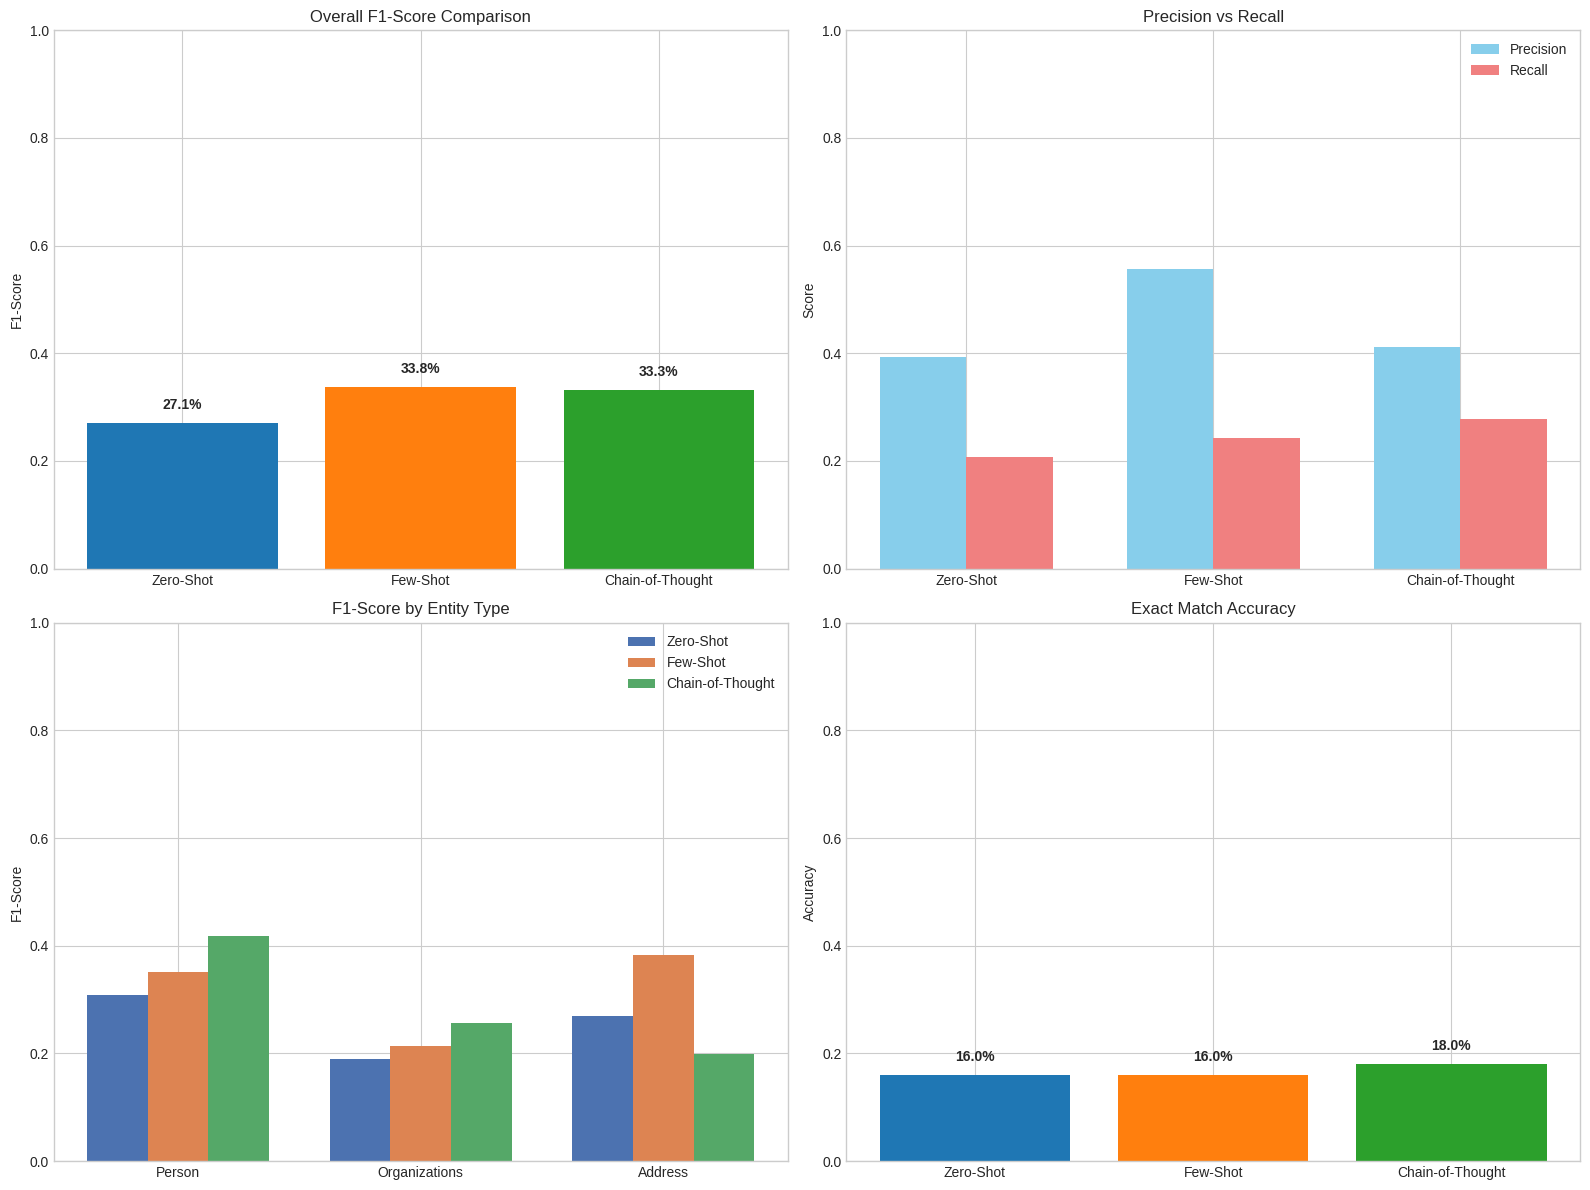

Visualization saved as 'prompt_engineering_results.png'


In [ ]:
# Create comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

methods = ['Zero-Shot', 'Few-Shot', 'Chain-of-Thought']

# 1. Overall F1-Score Comparison
f1_scores = [comparison_dict[m]['overall_entity_metrics']['f1'] for m in methods]
axes[0, 0].bar(methods, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0, 0].set_ylabel('F1-Score')
axes[0, 0].set_title('Overall F1-Score Comparison')
axes[0, 0].set_ylim([0, 1])
for i, v in enumerate(f1_scores):
    axes[0, 0].text(i, v + 0.02, f'{v:.1%}', ha='center', va='bottom', fontweight='bold')

# 2. Precision vs Recall
precisions = [comparison_dict[m]['overall_entity_metrics']['precision'] for m in methods]
recalls = [comparison_dict[m]['overall_entity_metrics']['recall'] for m in methods]
x = np.arange(len(methods))
width = 0.35
axes[0, 1].bar(x - width/2, precisions, width, label='Precision', color='skyblue')
axes[0, 1].bar(x + width/2, recalls, width, label='Recall', color='lightcoral')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Precision vs Recall')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(methods)
axes[0, 1].legend()
axes[0, 1].set_ylim([0, 1])

# 3. Per-Type F1 Scores
entity_types = ['person', 'organizations', 'address']
type_labels = ['Person', 'Organizations', 'Address']
x = np.arange(len(entity_types))
width = 0.25

for i, method in enumerate(methods):
    f1_by_type = [comparison_dict[method]['per_entity_type'][t]['f1'] for t in entity_types]
    axes[1, 0].bar(x + i*width, f1_by_type, width, label=method)

axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_title('F1-Score by Entity Type')
axes[1, 0].set_xticks(x + width)
axes[1, 0].set_xticklabels(type_labels)
axes[1, 0].legend()
axes[1, 0].set_ylim([0, 1])

# 4. Exact Match Accuracy
exact_match = [comparison_dict[m]['accuracy'] for m in methods]
axes[1, 1].bar(methods, exact_match, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Exact Match Accuracy')
axes[1, 1].set_ylim([0, 1])
for i, v in enumerate(exact_match):
    axes[1, 1].text(i, v + 0.02, f'{v:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('prompt_engineering_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'prompt_engineering_results.png'")


### 5.4 Results Summary Table

In [ ]:
# Results summary table
summary_data = []

for method_name in ['Zero-Shot', 'Few-Shot', 'Chain-of-Thought']:
    eval_results = comparison_dict[method_name]
    
    row = {
        'Method': method_name,
        'Exact Match': f"{eval_results['accuracy']:.1%}",
        'Overall F1': f"{eval_results['overall_entity_metrics']['f1']:.1%}",
        'Precision': f"{eval_results['overall_entity_metrics']['precision']:.1%}",
        'Recall': f"{eval_results['overall_entity_metrics']['recall']:.1%}",
        'Person F1': f"{eval_results['per_entity_type']['person']['f1']:.1%}",
        'Org F1': f"{eval_results['per_entity_type']['organizations']['f1']:.1%}",
        'Address F1': f"{eval_results['per_entity_type']['address']['f1']:.1%}",
    }
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

print("\nResults Summary:")
display(summary_df)

# Save
summary_df.to_csv('prompt_engineering_results.csv', index=False)
print("\nSaved to prompt_engineering_results.csv")



Results Summary:


,Method,Exact Match,Overall F1,Precision,Recall,Person F1,Org F1,Address F1
0,Zero-Shot,16.0%,27.1%,39.4%,20.7%,30.9%,18.9%,27.0%
1,Few-Shot,16.0%,33.8%,55.6%,24.3%,35.1%,21.3%,38.3%
2,Chain-of-Thought,18.0%,33.3%,41.3%,27.9%,41.8%,25.6%,19.9%



Saved to prompt_engineering_results.csv
